![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

print(data.info())
# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
print(data.info())
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    400000 non-null  int64 
 1   Year     400000 non-null  int64 
 2   Mileage  400000 non-null  int64 
 3   State    400000 non-null  object
 4   Make     400000 non-null  object
 5   Model    400000 non-null  object
dtypes: int64(3), object(3)
memory usage: 18.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10495 entries, 7 to 399976
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Price    10495 non-null  int64 
 1   Year     10495 non-null  int64 
 2   Mileage  10495 non-null  int64 
 3   Model    10495 non-null  object
dtypes: int64(3), object(1)
memory usage: 410.0+ KB
None


,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [ ]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [ ]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

EXPERIMENTO1: Max Accuracy 0.8816397228637414 se obtuvo con un arbol MANUAL de Profundidad=5


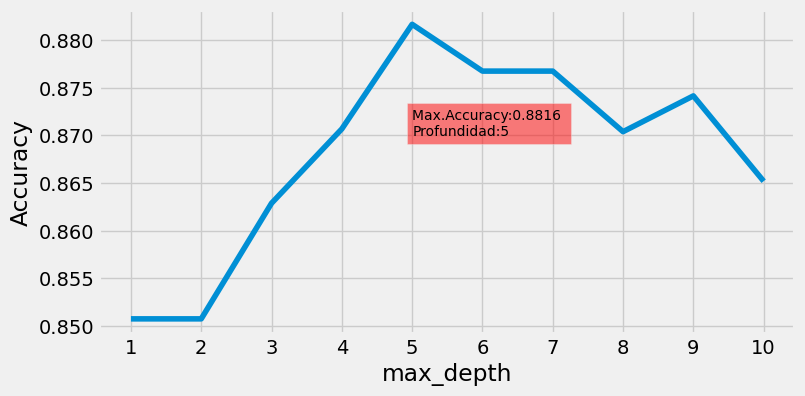

EXPERIMENTO2:Max Accuracy  con Cross Validation 0.8773996305810916 se obtuvo con un arbol SKLEARN de Profundidad=7


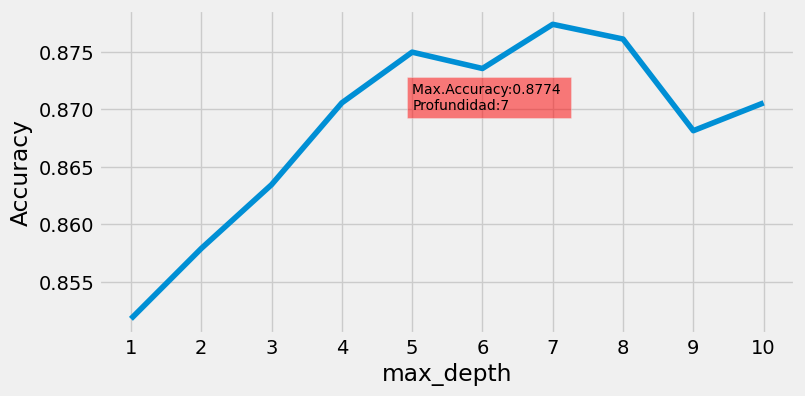

EXPERIMENTO2:Desempeño Real  0.875 se obtuvo con un arbol SKLEARN de Profundidad=7


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('fivethirtyeight')
from sklearn.metrics import accuracy_score
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    features = range(X.shape[1])
    best_split = [0, 0, 0]  # j, split, gain
    # Para todas las varibles 
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
            if gain > best_split[2]:
                best_split = [j, split, gain]
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
   
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    return tree

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
          
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
            
   
    return predicted

#MAIN

# Definición de parámetros y criterios de parada

num_pct = 10
max_features = None
min_gain=0.001
max_depth= 10
accuracy_scores=np.zeros(max_depth)
for depth in range(1,max_depth + 1):
  tree = tree_grow(X_train, y_train, level=0, min_gain=min_gain, max_depth=depth, num_pct=num_pct)
  yPred= tree_predict(X_test, tree)
  accuracy_scores[depth-1] = accuracy_score(y_test, yPred)

index_max= np.argmax(accuracy_scores)
max_accuracy= np.max(accuracy_scores)
print(f'EXPERIMENTO1: Max Accuracy {max_accuracy} se obtuvo con un arbol MANUAL de Profundidad={index_max+1}')
acc_arbolmanual = max_accuracy
# Gráfica max_depth versus  Accuracy
figure(figsize = (8, 4), dpi = 100)
plt.plot(range(1,max_depth+1), accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.xticks(range(1,max_depth+1))
plt.grid(visible=True)
plt.text(5, 0.870, "Max.Accuracy:{:.4f} \nProfundidad:{}".format(max_accuracy,index_max + 1),fontsize = 10, 
         bbox = dict(facecolor = 'red', alpha = 0.5))
plt.show()



# EXPERMIENTO 2 - Decision Tree SKLEARN
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
max_depth= 10
max_features = None
accuracy_scores=np.zeros(max_depth)
for depth in range(1, max_depth +1):
  tree= DecisionTreeClassifier(max_features= max_features,max_depth=depth, random_state=0)
  accuracy_scores[depth-1] = cross_val_score(tree,X_train,y_train,cv=5, scoring='accuracy').mean()
  index_max= np.argmax(accuracy_scores)
max_accuracy= np.max(accuracy_scores)
print(f'EXPERIMENTO2:Max Accuracy  con Cross Validation {max_accuracy} se obtuvo con un arbol SKLEARN de Profundidad={index_max+1}')
# Gráfica max_depth versus  Accuracy
figure(figsize = (8, 4), dpi = 100)
plt.plot(range(1,max_depth+1), accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.xticks(range(1,max_depth+1))
plt.grid(visible=True)
plt.text(5, 0.870, "Max.Accuracy:{:.4f} \nProfundidad:{}".format(max_accuracy,index_max + 1),fontsize = 10, 
         bbox = dict(facecolor = 'red', alpha = 0.5))
plt.show()
#Desempenio Real 
tree= DecisionTreeClassifier(max_features= max_features,max_depth=index_max+1, random_state=0)
tree.fit(X_train, y_train)
yPred= tree.predict(X_test)
acc_arbolsklearn =accuracy_score(y_test, yPred)
print(f'EXPERIMENTO2:Desempeño Real  {accuracy_score(y_test, yPred)} se obtuvo con un arbol SKLEARN de Profundidad={index_max+1}')



# Análisis
***

### Experimento 1:

- Este experimento fue un árbol manual, en el cual se calibró la profundidad , obteniéndose un accuracy de ***0.8816*** con un nivel 5 de profundidad.

### Experimento 2:
- Este experimento se realizó con un árbol de Sklearn y se calibró la profundidad con cross validation de 5 pliegues, obteniéndose un mejor árbol con profundidad igual 7 y con un accuracy en promedio de 0.87783. 
- El desempeño real fue medido contra dataset de test y el accuracy fue ***0.875***. Esto significa que el árbol esta generalizando bien en ambos datasets(Train/Test)


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

Max Accuracy 0.8836605080831409 fue obtenido con un Bagging de 10 arboles de Profundidad=6


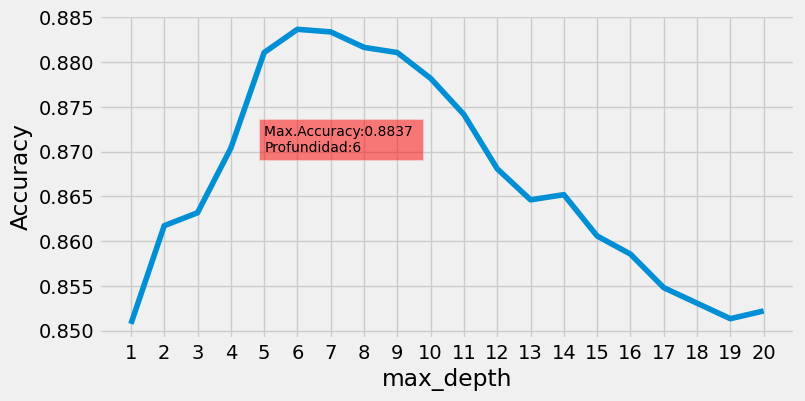

In [ ]:
from sklearn.tree import DecisionTreeClassifier
np.random.seed(123)
n_samples = X_train.shape[0]
n_estimators = 10

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]
seeds = np.random.randint(1, 10000, size=n_estimators)
trees = {}
max_depth = 20
accuracy_scores=np.zeros(max_depth)
for depth in range(1, max_depth +1):
  for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features=None,max_depth=depth, random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
  # Predicción para los datos del set de test con cada modelo
  y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
  for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)
  # Votación mayoritaria
  yPred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)
  # Desempeño al hacer votación mayoritaria
  accuracy_scores[depth-1]= accuracy_score( y_test,yPred)

index_max= np.argmax(accuracy_scores)
max_accuracy= np.max(accuracy_scores)
print(f'Max Accuracy {max_accuracy} fue obtenido con un Bagging de 10 arboles de Profundidad={index_max+1}')
acc_baggingmanual = max_accuracy
# Gráfica max_depth versus Accuracy
figure(figsize = (8, 4), dpi = 100)
plt.plot(range(1,max_depth+1), accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.ylabel('Accuracy')
plt.xticks(range(1,max_depth+1))
plt.grid(visible=True)
plt.text(5, 0.870, "Max.Accuracy:{:.4f} \nProfundidad:{}".format(max_accuracy,index_max + 1),fontsize = 10, 
         bbox = dict(facecolor = 'red', alpha = 0.5))
plt.show()



# Análisis
***
 - Este modelo fue construido con un 10 árboles de decisión con ***max_feartures = None***, lo que significa que los árboles crecen hasta que las hojas sean puras o hasta que las hojas contengan menos de 2 muestras.
 - Se hizo una calibración manual del max_depth, resultando un bagging de 10 árboles con 6 niveles de profundidad y un accuracy de ***0.883***

 - El accuracy de este modelo con la calibración fue ligeramente menor al del árbol con sklearn

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

Experimento 1: Accuracy de BaggingClassifier con SKLEAR y todos parametros por defecto:0.8654734411085451

Experimento 2:Max Accuracy con Cross Validation 0.8687236445288292 fue obtenido con un bagging de 10 arboles de Profundidad=8


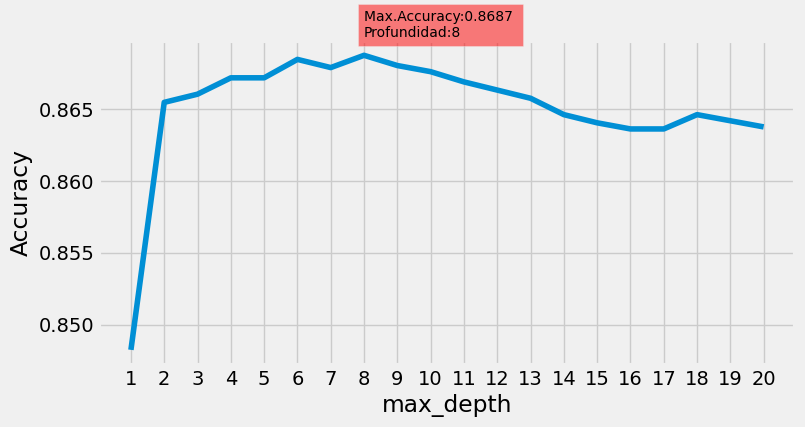

Experimento 2:Desempeño Real  0.8712471131639723 fue obtenido con un bagging de 10 arboles de Profundidad=8


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('fivethirtyeight')
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import cross_val_score

#Experimento 1

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=10, max_features=np.log2(X_train.shape[1])/X_train.shape[1], 
                              bootstrap=True, random_state=0)
bag_clf.fit(X_train, y_train)
yPred= bag_clf.predict(X_test)
acc_baggingsklearn = accuracy_score(y_test, yPred)
print(f'Experimento 1: Accuracy de BaggingClassifier con SKLEAR y todos parametros por defecto:{accuracy_score(y_test, yPred)}\n')


# Experimento 2
max_depth = 20
accuracy_scores=np.zeros(max_depth)
for depth in range(1, max_depth +1):
  bag_clf = BaggingClassifier(DecisionTreeClassifier(max_depth=depth), n_estimators=10, max_features=np.log2(X_train.shape[1])/X_train.shape[1], 
                              bootstrap=True, random_state=0)
  accuracy_scores[depth-1] = cross_val_score(bag_clf,X_train,y_train,cv=5, scoring='accuracy').mean()

index_max= np.argmax(accuracy_scores)
max_accuracy= np.max(accuracy_scores)
print(f'Experimento 2:Max Accuracy con Cross Validation {max_accuracy} fue obtenido con un bagging de 10 arboles de Profundidad={index_max + 1}')
# Gráfica max_depth versus Accuracy
figure(figsize = (8, 4), dpi = 100)
plt.plot(range(1,max_depth+1), accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

plt.xticks(range(1,max_depth+1))
plt.grid(visible=True)
plt.text(8, 0.870, "Max.Accuracy:{:.4f} \nProfundidad:{}".format(max_accuracy,index_max + 1),fontsize = 10, 
         bbox = dict(facecolor = 'red', alpha = 0.5))
plt.show()

#Desempeno real
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_depth=index_max + 1), n_estimators=10, max_features=np.log2(X_train.shape[1])/X_train.shape[1], 
                              bootstrap=True, random_state=0)
bag_clf.fit(X_train, y_train)
yPred= bag_clf.predict(X_test)
acc_baggingsklearn = accuracy_score(y_test, yPred)
print(f'Experimento 2:Desempeño Real  {accuracy_score(y_test, yPred)} fue obtenido con un bagging de 10 arboles de Profundidad={index_max + 1}')







# Análisis
***
Aqui, se llevaron a cabo dos experimentos, a saber:

### Experimento 1:

- Un modelo bagging de 10 arboles con sklearn  y `max_features` igual a `log(n_features)` y empleando todos los valores por defecto de los demas parametros. Por defecto,  `max_features=1.0`, lo que significa que para construir cada árbol emplea el 100% de los features. En este ejercicio, en cambio, se está empleando un parte de los features para construir cada árbol dentro del ensamblado.

- Se obtiene un accuracy de 0.8654 sin calibracion de parametros.


### Experimento 2:

- Este experimento se realizó con un bagging de 10 arboles y se calibró la profundidad con cross validation de 5 pliegues, obteniéndose un mejor árbol con profundidad igual 8 y con un accuracy en promedio de 0.8687. 
- El desempeño real fue medido contra dataset de test y el accuracy fue ***0.8712***. Esto significa que el ensamblado en paralelo esta generalizando bien en ambos datasets(Train/Test)

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Experimento 1: Random Forest con SKLEARN

from sklearn.metrics import accuracy_score
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
yPred = clf.predict(X_test)
print(f'Experimento 1: Accuracy de RandomForest con SKLEAR y todos parametros por defecto:{accuracy_score(y_test, yPred)}\n')
acc_RFSinCalibracion = accuracy_score(y_test, yPred)

#Experimento 2: Random Forest con SKLEARN calibrando n_estimators y max_features
parametros = {
            'n_estimators':[50,  70, 100, 150, 200],
            'max_features':[0.3,'sqrt','log2']}
accuracy_scores = np.zeros((len(parametros['n_estimators']), len(parametros['max_features'])))
for e,estimator in  enumerate(parametros['n_estimators']):
  for f, feature in enumerate(parametros['max_features']):
    rnd_clf = RandomForestClassifier(n_estimators= estimator,  max_features=feature,oob_score =True, random_state=0)
    accuracy_scores[e][f] = cross_val_score(rnd_clf,X_train,y_train,cv=5, scoring='accuracy').mean()
maximo = np.amax(accuracy_scores)
indexes_max= np.where(accuracy_scores == maximo)
for e,f in list(zip(indexes_max[0], indexes_max[1])):
    print(f'Experimento 2: Mejor Modelo con Cross Validation n_estimadores:{parametros["n_estimators"][e]} Max_features:{parametros["max_features"][f]} Final Accuracy: {accuracy_scores[e][f]} ')
    

#Desempeno real
for e,f in list(zip(indexes_max[0], indexes_max[1])):
  rnd_clf = RandomForestClassifier(n_estimators= parametros["n_estimators"][e],  max_features=parametros["max_features"][f],oob_score =True, random_state=0)
  rnd_clf.fit(X_train, y_train)
  yPred= rnd_clf.predict(X_test)
  acc_RFConCalibracion = accuracy_score(y_test, yPred)
  print(f'Experimento 2: Desempeño Real Modelo n_estimadores:{parametros["n_estimators"][e]} Max_features:{parametros["max_features"][f]} Final Accuracy: {acc_RFConCalibracion} ')
   


Experimento 1: Accuracy de RandomForest con SKLEAR y todos parametros por defecto:0.8273672055427251

Experimento 2: Mejor Modelo con Cross Validation n_estimadores:70 Max_features:sqrt Final Accuracy: 0.8496640956970886 
Experimento 2: Mejor Modelo con Cross Validation n_estimadores:70 Max_features:log2 Final Accuracy: 0.8496640956970886 
Experimento 2: Desempeño Real Modelo n_estimadores:70 Max_features:sqrt Final Accuracy: 0.8285219399538106 
Experimento 2: Desempeño Real Modelo n_estimadores:70 Max_features:log2 Final Accuracy: 0.8285219399538106 


# Análisis
***
Aqui, se llevaron a cabo dos experimentos, a saber:

### Experimento 1:

- Un modelo RandomForest empleando todos los valores por defecto de los  parámetros. Por defecto,  `n_estimators=100`, lo que significa que el ensamblado tendrá 100 árboles. Por otro lado, el criterio para medir la calidad de un split es ***gini impurity*** ; Max-Features = sqrt (n-features) el cual usa una porción de las features para cada split creando diversidad.

| Parámetro      | Valor |
| ----------- | ----------- |
| criterion      | gini       |
| max_features   | auto => max_features=sqrt(n_features)        |  
| bootstrap   | True        |
| max_depth   | None        |

- Se obtiene un accuracy de 0.8273 sin calibración de parametros, moderadamente menor a los otros modelos.


### Experimento 2:

- Este experimento se realizó con un RandomForest calibrando el numero de estimadores y max_features. Para lograr este proposito, se selecciono unos lista de n_estimadores y una lista de valores para max_features

             `n_estimators':[50, 70, 100, 150, 200, 300, 400] `,  
             `max_features':[0.3,'sqrt','log2', None] `

 Se realizó cross validation, obteniéndose dos modelos  RandomForest con las siguiente topología:


 | RandomForest 1      |Accuracy= 0.8496 |
| ----------- | ----------- |
| criterion      | gini       |
| max_features   | sqrt(n_features)        |  
| bootstrap   | True        |
| n_estimators   | 70        |
---


| RandomForest 2      |Accuracy= 0.8496 |
| ----------- | ----------- |
| criterion      | gini       |
| max_features   | log2(n_features)        |  
| bootstrap   | True        |
| n_estimators   | 70        |

- El desempeño real fue medido contra dataset de test y el accuracy fue ***0.8275***. Esto significa que este modelo ha sido el de menor desempeño hasta ahora con respecto a los demás ejecutados.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [ ]:

parametros = {
            'n_estimators': [50, 70, 100, 150, 200, 300, 400],
            'max_depth':[5, 7, 10, 20, None],
            'max_features':[0.3,'sqrt', 'log2', X_train.shape[1]]}
accuracy_scores = np.zeros((len(parametros['n_estimators']), len(parametros['max_depth']),  len(parametros['max_features']))) # Grid para almacenar accuracy scores 
for e,estimator in  enumerate(parametros['n_estimators']):
  for d,depth in enumerate(parametros['max_depth']):
    for f,feature in enumerate(parametros['max_features']):
      rnd_clf = RandomForestClassifier(n_estimators= estimator, max_depth = depth,  max_features=feature, oob_score =True, random_state=0)
      accuracy_scores[e][d][f]= cross_val_score(rnd_clf,X_train,y_train,cv=5, scoring='accuracy').mean()
maximo = np.amax(accuracy_scores)
indexes_max= np.where(accuracy_scores == maximo)
for e,d,f in list(zip(indexes_max[0],indexes_max[1],indexes_max[2])):
  print (f'Mejor Modelo cross validatin n_estimadores:{parametros["n_estimators"][e]} Profundidad:{parametros["max_depth"][d]} Max_Feature:{parametros["max_features"][f]} Final Accuracy {accuracy_scores[e][d][f]} ')
  acc_RFConCalibracion = accuracy_scores[e][d][f]

#Desempeno Real
for e,d,f in list(zip(indexes_max[0],indexes_max[1],indexes_max[2])):
  rnd_clf = RandomForestClassifier(n_estimators= parametros["n_estimators"][e],  
                                 max_depth= parametros["max_depth"][d],
                                 max_features=parametros["max_features"][f],
                                 oob_score =True, 
                                 random_state=0)
  rnd_clf.fit(X_train, y_train)
  yPred= rnd_clf.predict(X_test)
  acc_RFConCalibracion = accuracy_score(y_test, yPred)
  print (f'Desempeño Real con modelo n_estimadores:{parametros["n_estimators"][e]} Profundidad:{parametros["max_depth"][d]} Max_Feature:{parametros["max_features"][f]} Final Accuracy {acc_RFConCalibracion} ')
 

Mejor Modelo cross validatin n_estimadores:70 Profundidad:7 Max_Feature:sqrt Final Accuracy 0.8859319537245696 
Mejor Modelo cross validatin n_estimadores:70 Profundidad:7 Max_Feature:log2 Final Accuracy 0.8859319537245696 
Desempeño Real con modelo n_estimadores:70 Profundidad:7 Max_Feature:sqrt Final Accuracy 0.8848152424942263 
Desempeño Real con modelo n_estimadores:70 Profundidad:7 Max_Feature:log2 Final Accuracy 0.8848152424942263 


# Análisis
***
- Para la calibración de parametros, se hizo uso de una grilla (arreglo 3D) para almacenar las diferentes scores de los accuracies de cada combinación de valores de los parametros, mediante cross validation.
- Respecto , al parametro ***n_estimators***, intuitivamente se podria pensar que entre mayor número de árboles, mayor es la variedad para aprender del ensamblado y por lo tanto mayor es su precisión. También, se pensaría que habria peligro de sobreajuste , si la cantidad de arboles es demasiado grande.  
En este experimento, lo que se puede observar es que despues de un cierto numero de árboles, no hay mas contribución de esos árboles extras porque los nuevos arboles esta altamente correlacionado en el sentido que son una copia de árboles previamente creados y por lo tanto no revelan más información de la que se ya  tenía en el ensamblado.

- Respecto, al parámetro ***max_features***, intuitivamente si el max_feature decrece, la correlación entre árboles disminuye porque hay mayor variedad. En este experimento, se tomo como punto de partida, 30% de los features, Sqrt(N), log2(N) y N donde N= total de features. Se obtuvo para este dataset en particular que Sqrt(N), log2(N) tiene un buen desempeno. Empleando cross validation , se obtiene la mejor combinación de parametros:  


 | RandomForest 1  |Accuracy= 0.8859 |
| ----------- | ----------- |
| criterion      | gini       |
| max_features   | sqrt(n_features)        |  
| bootstrap   | True        |
| n_estimators   | 70        |
| max_depth   | 7        |

---

| RandomForest 2      |Accuracy= 0.8859 |
| ----------- | ----------- |
| criterion      | gini       |
| max_features   | log2(n_features)        |  
| bootstrap   | True        |
| n_estimators   | 70        |
| max_depth   | 7        |



- El desempeño real fue medido contra dataset de test y el accuracy fue ***0.88848***. Esto significa que este modelo ha sido el mejor hasta ahora con respecto a los anteriores.


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [ ]:
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
clf = XGBClassifier(random_state=0)
clf.fit(X_train, y_train)
yPred = clf.predict(X_test)
print(f'XGBoost sin calibrar {accuracy_score(y_test, yPred)}')
acc_XGBoostSinCalibracion = accuracy_score(y_test, yPred)

XGBoost sin calibrar 0.8845265588914549


# Análisis
***


- Un modelo XGBoost sin calibrar empleando todos los valores por defecto de los  parámetros. Por defecto,   estos son los valores :

| Parámetro      | Valor |
| ----------- | ----------- |
| max_depth      | 3       |
| objective   | binary:logistic        |  
| gamma   | 0        |
| n_estimators   | 100        |
| learning_rate   | 0.1        |
| colsample_bytree   |1       |
| reg_alpha   |0      |
| reg_lambda   |1       |


- Gamma es una pseudo regularizacion para podar el árbol y no dejarlo crecer mucho y evitar sobreajuste.

- colsample_bytree, porcentaje de las N-features que escoge aleatoriamente para construir cada arbol en el ensamblado secuencial.

- learning rate refleja cuán rápido el modelo aprende. Este parametro modifica la contribucion de cada árbol en el proceso de aprendizaje.

- reg_alpha y reg_lambda son parametros de regularizacion L1 y L2 respectivamente.

- El accuracy de este modelo  es 0.8845 sin ningun tipo de calibracion.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [ ]:
parametros = {
            'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,0,4],# escala la contribucion de cada arbol
            'gamma':[0,2, 3,5,10,20],  # Pseudo regulaizador para podar el arbol y no hacerlo profundo
            'colsample_bytree':[ 0.5,0.6,0.7, 0.9, 1]}
accuracy_scores = np.zeros((len(parametros['learning_rate']), len(parametros['gamma']),  len(parametros['colsample_bytree']))) # Grid para almacenar accuracy scores 
for lr,learning_rate in  enumerate(parametros['learning_rate']):
  for g,gamma in enumerate(parametros['gamma']):
    for c,colsample_bytree in enumerate(parametros['colsample_bytree']):
      clf = XGBClassifier(learning_rate= learning_rate, gamma = gamma,  colsample_bytree=colsample_bytree, random_state=0)
      accuracy_scores[lr][g][c]= cross_val_score(clf,X_train,y_train,cv=5, scoring='accuracy').mean()
maximo = np.amax(accuracy_scores)
indexes_max= np.where(accuracy_scores == maximo)
for lr,g,c in list(zip(indexes_max[0],indexes_max[1],indexes_max[2])):
  print (f'Mejor Modelo Learning Rate: {parametros["learning_rate"][lr]} Gamma:{parametros["gamma"][g]} colsample_bytree:{parametros["colsample_bytree"][c]} Final Accuracy {accuracy_scores[lr][g][c]} ')

for lr,g,c in list(zip(indexes_max[0],indexes_max[1],indexes_max[2])):
  clf = XGBClassifier(learning_rate= parametros["learning_rate"][lr], 
                      gamma = parametros["gamma"][g], 
                      colsample_bytree=parametros["colsample_bytree"][c], 
                      random_state=0)
  clf.fit(X_train, y_train)
  yPred= clf.predict(X_test)
  acc_XGBoostConCalibracion = accuracy_score(y_test, yPred)
  print (f'Desempenio Real Learning Rate: {parametros["learning_rate"][lr]} Gamma:{parametros["gamma"][g]} colsample_bytree:{parametros["colsample_bytree"][c]} Final Accuracy {acc_XGBoostConCalibracion} ')
 

Mejor Modelo Learning Rate: 0.1 Gamma:5 colsample_bytree:1 Final Accuracy 0.8843671300073499 
Desempenio Real Learning Rate: 0.1 Gamma:5 colsample_bytree:1 Final Accuracy 0.8822170900692841 


# Análisis
***
- Para la calibración de parámetros, se hizo uso de una grilla (arreglo 3D) para almacenar las diferentes accuracies de cada combinación de valores de los parametros, mediante cross validation.

- Se obtiene la mejor combinación de parametros:  


 | XGBoost  |Accuracy= 0.8843 |
| ----------- | ----------- |
| gamma   | 5        |
| n_estimators   | 100        |
| learning_rate   | 0.1        |
| colsample_bytree   |1 -> para cada arbol toma el 100% de los features      |





- El desempeño real fue medido contra dataset de test y el accuracy fue ***0.8822***. Esto significa que este modelo ha sido el mejor hasta ahora con respecto a los anteriores.


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

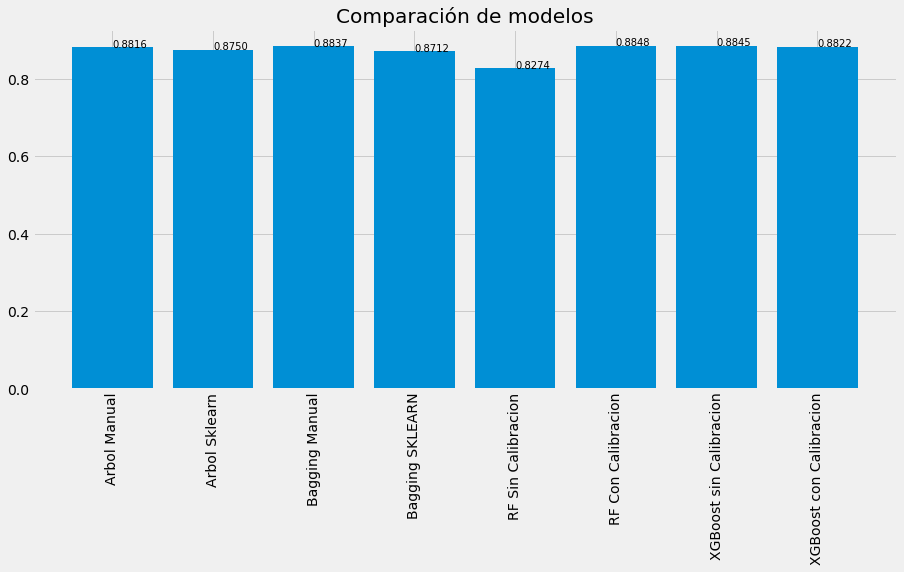

In [ ]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos")
ejeX = ['Arbol Manual','Arbol Sklearn', 'Bagging Manual','Bagging SKLEARN','RF Sin Calibracion', 'RF Con Calibracion', 'XGBoost sin Calibracion', 'XGBoost con Calibracion']
ejeY = [acc_arbolmanual, acc_arbolsklearn, acc_baggingmanual, acc_baggingsklearn, acc_RFSinCalibracion, acc_RFConCalibracion, acc_XGBoostSinCalibracion, acc_XGBoostConCalibracion]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],"{:.4f}".format(y[i]),fontsize=10)
addlabels(ejeX,ejeY,plt)
plt.xticks(fontsize=14, rotation=90)
plt.show()

Análisis
***
- Los dos mejores modelos en desempeno fueron rabdomForest con calibración de hiperparámetros y el XGBoost sin calibración, con un score de accuracies de 0.8848 y 0.8845 respectivamente.

- Básicamente, XGBoost se comportó muy bien sin necesidad de extra calibración